# Homework 3
Christopher Beam

800927393

## Problem 1

In [11]:
# Setup
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_breast_cancer
from collections import Counter
import seaborn as sns

In [12]:
data = load_breast_cancer()
X = data.data
Y = data.target

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
tempOnes_train = np.ones((len(Y_train), 1))
tempOnes_test = np.ones((len(Y_test),1))
iterations = 100

In [14]:
# Scale the input
X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_std = X_scaler.transform(X_train)
X_test_std = X_scaler.transform(X_test)

In [15]:
def naive_bayes(sample, means, variances, prob):
    out = []
    for i in range(sample.shape[0]):
        temp = (1/np.sqrt(2 * np.pi * variances)) * np.exp((-(sample[i,:] - means) ** 2)/(2 * variances))
        out.append(np.prod((temp), axis=1) * (prob))
    return np.array(out)

def get_stats(input, targets):
    count = Counter(targets)
    keys = count.keys()

    means = []
    for k in keys:
        means.append(np.mean(input[targets==k], axis=0))
    means = np.array(means)

    variances = []
    for k in keys:
        variances.append(np.var(input[targets==k], axis=0, ddof=1))
    variances = np.array(variances)

    count = np.array(list(count.values()))
    prob = count/sum(count)
    return means, variances, prob

def pca(X, n):
    N = np.min(np.array([n, X.shape[1]]))
    covar_mat = np.cov(X.T)
    eigen_val, eigen_vec = np.linalg.eigh(covar_mat)

    sort_idx = np.argsort(eigen_val)[::-1]
    sorted_vec = eigen_vec[:,sort_idx]

    eigen_vec_subset = sorted_vec[:,0:N]
    return eigen_vec_subset.T.dot(X.T).T

In [16]:
means, variances, prob = get_stats(X_train, Y_train)

Accuracy: 0.04
Precision for 0: 0.60
Recall for 0: 0.07
Precision for 1: 0.40
Recall for 1: 0.03


Text(0.5, 427.9555555555555, 'Predicted Label')

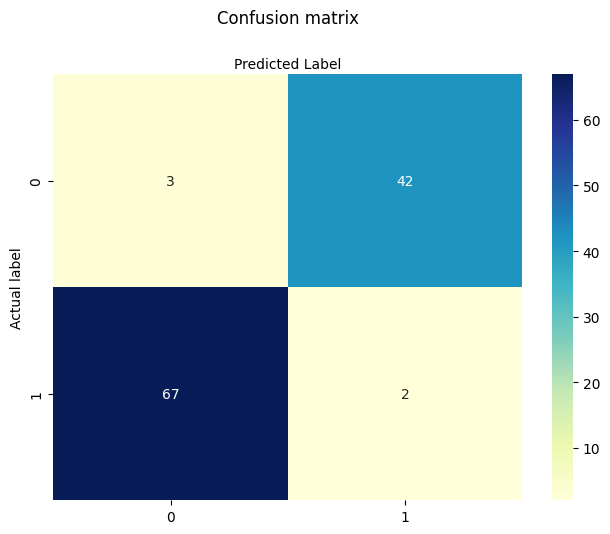

In [17]:
out = naive_bayes(X_test, means, variances, prob)
pred = np.argmax(out, axis=1)
cnf_mat = confusion_matrix(Y_test, pred)

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision for 0: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall for 0: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))
print("Precision for 1: {:.2f}".format(cnf_mat[1,1]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall for 1: {:.2f}".format(cnf_mat[1,1]/(cnf_mat[1,0] + cnf_mat[1,1])))

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

## Problem 2

In [18]:
# Log Regression and Gradient_descent
def h_func(X,theta):
    return 1/(1+np.exp(-X.dot(theta)))

def logReg(X, Y, theta):
    H = h_func(X,theta)
    errors = -Y*np.log(H)-(1-Y)*np.log(1-H)
    return np.mean(errors)

def gradDes_paramPen(X_train, Y_train, theta, alpha, iterations, beta):
    costArray = np.zeros(iterations)
    for i in range(iterations):
        pred = h_func(X_train,theta)
        errors = np.subtract(pred, Y_train)
        delta = (alpha / len(Y_train)) * (X_train.transpose().dot(errors))
        delta[1:] = delta[1:] + beta * theta[1:]
        theta = theta - delta
        costArray[i] = logReg(X_train, Y_train, theta)
    return theta, costArray

K with maximum accuracy = 1
K with maximum precision for 0 = 1
K with maximum recall for 0 = 1
K with maximum precision for 1 = 5
K with maximum recall for 1 = 1


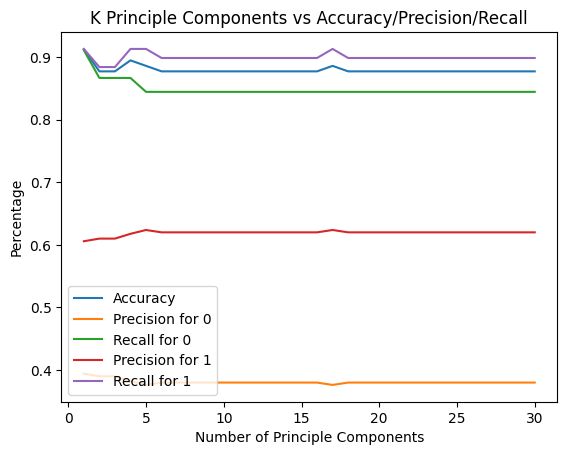

In [19]:
acc_list = []
prec0_list = []
recall0_list = []
prec1_list = []
recall1_list = []
for k in range(1,31):
    X_train_std_new = pca(X_train_std, k)
    X_test_std_new = pca(X_test_std, k)

    X_train_std_new = np.hstack((tempOnes_train, X_train_std_new))
    X_test_std_new = np.hstack((tempOnes_test, X_test_std_new))

    theta_x1 = np.zeros(k+1)
    theta_x1, loss = gradDes_paramPen(X_train_std_new, Y_train, theta_x1, 0.1, iterations, 0)
    means, variances, prob = get_stats(X_train_std_new, Y_train)
    H = h_func(X_test_std_new, theta_x1)
    cnf_mat = confusion_matrix(Y_test, H.round())

    acc_list.append((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat))
    prec0_list.append(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1]))
    recall0_list.append(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1]))
    prec1_list.append(cnf_mat[1,1]/(cnf_mat[0,0] + cnf_mat[1,1]))
    recall1_list.append(cnf_mat[1,1]/(cnf_mat[1,0] + cnf_mat[1,1]))

print("K with maximum accuracy = {}".format(np.argmax(acc_list)+1))
print("K with maximum precision for 0 = {}".format(np.argmax(prec0_list)+1))
print("K with maximum recall for 0 = {}".format(np.argmax(recall0_list)+1))
print("K with maximum precision for 1 = {}".format(np.argmax(prec1_list)+1))
print("K with maximum recall for 1 = {}".format(np.argmax(recall1_list)+1))

plt.plot(range(1,31), acc_list, label="Accuracy")
plt.plot(range(1,31), prec0_list, label="Precision for 0")
plt.plot(range(1,31), recall0_list, label="Recall for 0")
plt.plot(range(1,31), prec1_list, label="Precision for 1")
plt.plot(range(1,31), recall1_list, label="Recall for 1")
plt.title("K Principle Components vs Accuracy/Precision/Recall")
plt.xlabel("Number of Principle Components")
plt.ylabel("Percentage")
plt.legend()

## Problem 3

K with maximum accuracy = 27
K with maximum precision for 0 = 21
K with maximum recall for 0 = 30
K with maximum precision for 1 = 7
K with maximum recall for 1 = 27


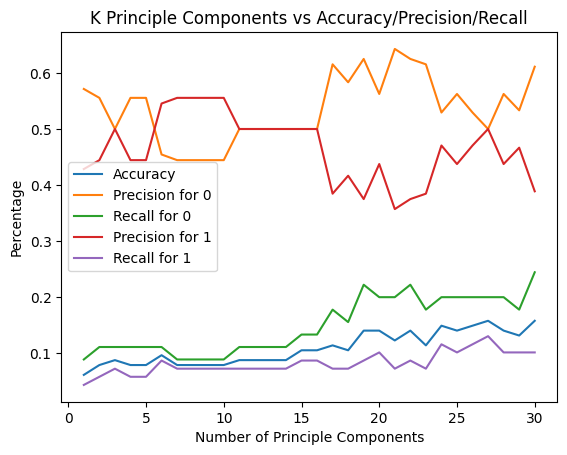

In [20]:
acc_list = []
prec0_list = []
recall0_list = []
prec1_list = []
recall1_list = []
for k in range(1,31):
    X_train_std_new = pca(X_train_std, k)
    X_test_std_new = pca(X_test_std, k)

    means, variances, prob = get_stats(X_train_std_new, Y_train)
    out = naive_bayes(X_test_std_new, means, variances, prob)
    pred = np.argmax(out, axis=1)
    cnf_mat = confusion_matrix(Y_test, pred)

    acc_list.append((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat))
    prec0_list.append(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1]))
    recall0_list.append(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1]))
    prec1_list.append(cnf_mat[1,1]/(cnf_mat[0,0] + cnf_mat[1,1]))
    recall1_list.append(cnf_mat[1,1]/(cnf_mat[1,0] + cnf_mat[1,1]))

print("K with maximum accuracy = {}".format(np.argmax(acc_list)+1))
print("K with maximum precision for 0 = {}".format(np.argmax(prec0_list)+1))
print("K with maximum recall for 0 = {}".format(np.argmax(recall0_list)+1))
print("K with maximum precision for 1 = {}".format(np.argmax(prec1_list)+1))
print("K with maximum recall for 1 = {}".format(np.argmax(recall1_list)+1))

plt.plot(range(1,31), acc_list, label="Accuracy")
plt.plot(range(1,31), prec0_list, label="Precision for 0")
plt.plot(range(1,31), recall0_list, label="Recall for 0")
plt.plot(range(1,31), prec1_list, label="Precision for 1")
plt.plot(range(1,31), recall1_list, label="Recall for 1")
plt.title("K Principle Components vs Accuracy/Precision/Recall")
plt.xlabel("Number of Principle Components")
plt.ylabel("Percentage")
plt.legend()